# Expected Epidemic Size of Mask Model

$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(\text{wear a mask}) = m$

$A_{L, 0}$ := Node v becomes **active** at level L given he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wears** a mask


## 1. Condition on num of neighbors from lower level







$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 0}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(A_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(A_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$I_0 \sim \operatorname{Binomial}\left(n, P(A_{L-1,0})\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, P(A_{L-1,1})\right)$


$P(A_{L, i} | B_k, N = n) = \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k-1-n}P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * P(A_{L-1, 0})^{k_0} * (1 - P(A_{L-1,0}))^{n - k_0} * P(A_{L-1, 1})^{k_1} * (1 - P(A_{L-1, 1}))^{k - 1 - n - k_1}$

where

$i = 0,1$

## 4. $P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, N = n, I_0 = k_0, I_1 = k_1$

### 4.1 $P(A_{L,0} | R)$

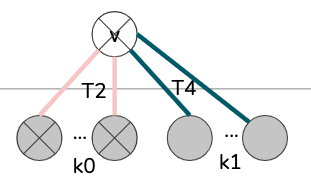

$P(A_{L,0} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - (1 - T_2)^{k_0} * (1 - T_4)^{k_1}$

### 4.1 $P(A_{L,1} | R)$

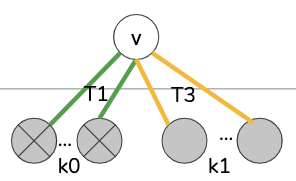

$P(A_{L,1} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v doesn't a mask} | R)$

$ = 1 - (1 - T_1)^{k_0} * (1 - T_3)^{k_1}$

T_mask1 : outward effeciency of masks

T_mask2 : inward effeciency of masks

# Parameters

In [1]:
import re
from os import listdir
from os.path import isfile, join
import json
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy.special import comb
from scipy import optimize 
import multiprocessing, time
from multiprocessing import Manager
from collections import defaultdict
import collections
# """
# Parameters setup.
# """
# T_mask1 = 0.4 # Outward impact of the mask
# T_mask2 = 0.6 # Inward impact of the mask
# T = 0.6 # Original virus transmissiblity
# m = 0.45 # P(people wear mask)
# nodeN = 200000
# rho = 1.0/nodeN


degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script

# T_list = list(generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m).values())

mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

# max_degree = 2 * degree_max # degree_inf



In [6]:
def generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m):
    T1 = T * T_mask1 
    T2 = T * T_mask1 * T_mask2
    
    T3 = T 
    T4 = T * T_mask2
    
    ## tmask2 ~ 1
    
#     T1 = T * T_mask1 * T_mask2 * m
#     T2 = T * T_mask1 * (1 - m)
#     T3 = T * (1 - m)
#     T4 = T * T_mask2 * m

    
    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}
    
#     print("T1: %.5f" %T1)
#     print("T2: %.5f" %T2)
#     print("T3: %.5f" %T3)
#     print("T4: %.5f" %T4)
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask1, T_mask2, T, m):
    trans_dict = generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m)
    T1 = trans_dict['T1']
    T2 = trans_dict['T2']
    T3 = trans_dict['T3']
    T4 = trans_dict['T4']

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    Q_dict = {
        "Q1": Q1,
        "Q2": Q2}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21,}
    

#     print("Q1: %.5f" %Q1)
#     print("Q2: %.5f" %Q2)

#     print("mu11: %.5f" %mu11)
#     print("mu12: %.5f" %mu12)
#     print("mu22: %.5f" %mu22)
#     print("mu21: %.5f" %mu21)
    
    print("mu11 + mu12", mu11 + mu12)
    print("mu22 + mu21", mu22 + mu21)
#     assert  == 1
    
    return Q_dict, mu_dict, trans_dict

In [27]:
'''
Collections of data loading functions
'''

def separate_number_chars(s):
    res = re.split('([-+]?\d+\.\d+)|([-+]?\d+)', s.strip())
    res_f = [r.strip() for r in res if r is not None and r.strip() != '']
    return res_f

def load_change_results(change_metric, model_names, paras_setting):
    '''
    Load ES Analysis Results
    Mask: parellel
    Mutation: parellel
    '''

    infection_size = dict()
    for model in model_names:
        infection_size[model] = dict()
        print("Model ", model)
        print("change ", change_metric)
        print(paras_setting)

                
        infection_size[model][change_metric] = dict()
        change_metric_path = model + '_ES_Analysis_change_' + change_metric
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]   
        infection_size[model][change_metric][paras_setting] = dict()

        exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Get the latest results
        print(exp_time)

        json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
        json_path_list = []

        json_path_list.append(json_path + 'infection_size0.json')
        json_path_list.append(json_path + 'infection_size1.json')
        json_path_list.append(json_path + 'infection_size.json')

        for i, json_path_i in enumerate(json_path_list):
            with open(json_path_i) as json_file:
                infection_size_mask = json.load(json_file)

            infection_size[model][change_metric][paras_setting][i] = \
            list(collections.OrderedDict(sorted(infection_size_mask.items())).values())

            infection_size[model][change_metric][paras_setting][i] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][i]]
    return infection_size        
            
def plot_mask_mutation_theory_change(change_metric, mean_degree_list, infection_size, model_names):    
    for paras_setting in infection_size[model_names[0]][change_metric].keys():
        
        paras = paras_setting.split('_')
        m = float(separate_number_chars(paras[0])[1])
        T = float(separate_number_chars(paras[1])[1])
        tm1 = float(paras[3])
        tm2 = float(paras[5])
        print("m: %.2f, T:%.2f, tm1:%.2f, tm2:%.2f" %(m,T,tm1,tm2))

        infection_size_mask = infection_size[model_names[0]][change_metric][paras_setting]
        infection_size_mu   = infection_size[model_names[1]][change_metric][paras_setting]

    
        plt.figure()
#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m + np.array(infection_size_mask[1]) * (1 - m), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m, 'g.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[1]) * (1 - m), 'b.')

#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]) * m, 'g.')
#         plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * (1 - m), 'b.')
# #         plt.plot(mean_degree_list, np.array(infection_size_mask[1]) , 'r.')

        plt.plot(mean_degree_list, np.array(infection_size_mu[2]), 'rx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[0]) , 'gx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[1]) , 'bx')

        plt.legend(["Avg        (Mask model)", "Mask      (Mask model)", "No mask(Mask model)", 
                    "Avg        (Mutation model)", "Strain-1 (Mutation model)", "Strain-2 (Mutation model)"])
        plt.xlabel("Mean Degree")
        plt.ylabel("Infection Fraction")
        title = "Theoretical Epidemic Size\nChange " + change_metric + "\nm:%.2f, T:%.2f, tm1:%.2f, tm2:%.2f"%(m, T, tm1, tm2)
        plt.title(title)         
        
def load_happyfeet_results(base_happy_path, metric='', para_setting='', exp_setting='', sim_model_name='', start_strain=0, from_sirius = True):    
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + \
                     metric + '/' + para_setting + '/' +  exp_setting
        exp_times = [f for f in listdir(happy_path) 
                 if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
        else:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'
    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    infection_size0 = defaultdict(list)
    infection_size1 = defaultdict(list)
    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        cpfiles = [f for f in listdir(happy_path + mdf)]
        infection_size0_cp_list = []
        infection_size1_cp_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
            infection_size0_cp_list.append(np.load(np_path + 'infSt1.npy'))
            infection_size1_cp_list.append(np.load(np_path + 'infSt2.npy'))
        
        infection_size0[md] = np.array(infection_size0_cp_list).mean()
        infection_size1[md] = np.array(infection_size1_cp_list).mean()
    
    infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())
    infection_size1_list = list(collections.OrderedDict(sorted(infection_size1.items())).values())
    return infection_size0_list, infection_size1_list, paras     

def load_old_path_sim_results(metric, exp_setting):
    sim_mask_path = '../../../Mask2Results_change_' + metric + '/'
    exp_times = [f for f in listdir(sim_mask_path) 
                     if f != '.ipynb_checkpoints' and exp_setting in f]
    exp_time = max(exp_times) # Compare the latest results
    np_path = sim_mask_path + exp_time + "/Results/start-mask/"
    if0 = np.load(np_path + "infSt1.npy")
    if1 = np.load(np_path + "infSt2.npy")
    
    with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
        paras_sim = json.load(js)
    return if0, if1, paras_sim

# Mask theory v.s. Mask Simulation

In [29]:
'''Load  ES analysis results'''
m = 0.6
metric_analysis = 'm'
para_setting = 'm'+ str(m) +'_T0.60_tm1_0.00_tm2_1.00'
# model_names = ['Maskplay', 'MutationParellel']
model_names = ['Maskplay', ]
change_metrics_names = ['m', 'T', 'tm']

infection_size = load_change_results(metric_analysis, model_names, para_setting)

Model  Maskplay
change  m
m0.6_T0.60_tm1_0.00_tm2_1.00
091209:29


In [26]:
'''Load simulation results made in Sep 11th using parellel'''
exp_setting = 'n5000_e100'
if0, if1, paras_sim = load_old_path_sim_results(metric_analysis, exp_setting)
paras_sim

{'n': 5000,
 'th': 0.01,
 'tm1': 0.0,
 'tm2': 1.0,
 'm': 0.6,
 'T': 1.0,
 'md': 10,
 'ns': 50,
 'meandegree': 10.0,
 'start_strain ': 2}

Text(0.5, 1.0, 'Theoretical Epidemic Size\nm0.6_T0.60_tm1_0.00_tm2_1.00')

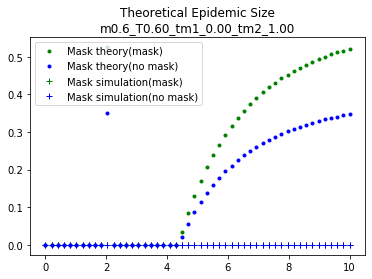

In [15]:
# plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][2]), 'r.')
plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][0]) * m, 'g.')
plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][1]) * (1  - m), 'b.')

# plt.plot(mean_degree_list, np.array(infection_size[model_names[1]][metric][para_setting][0]) + np.array(infection_size[model_names[1]][metric][para_setting][1]), 'rx')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][0], 'gx')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][1], 'bx')

# plt.plot(mean_degree_list, np.array(if0)  + np.array(if1), 'r+')
plt.plot(mean_degree_list, np.array(if0) , 'g+')
plt.plot(mean_degree_list, np.array(if1) , 'b+')
plt.legend(["Mask theory(mask)", 
            "Mask theory(no mask)",
#             "Mutation theory(Q1)", 
#             "Mutation theory(Q2)",
           "Mask simulation(mask)", 
            "Mask simulation(no mask)",],)
title = "Theoretical Epidemic Size"  + "\n" + para_setting
plt.title(title)
# plot_mask_mutation_theory_change(metric, mean_degree_list, infection_size, model_names)

In [14]:
# '''Load  simulation results copied from happyfeet'''
# # happy_path = '../../../happyfeet/ss1/'
# # if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = False)

# '''Load  simulation results from sirius(new path)'''
# sim_model_names = ['Mask2']
# base_happy_path = '../../../'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp100'
# sim_model_name = sim_model_names[0]

# if0, if1, paras = load_happyfeet_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     2)

# if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = True)